In [1]:
from collections import defaultdict
from graphviz import Digraph
from IPython.display import display

In [2]:
class User:
    def __init__(self, name, department):
        self.name = name
        self.apps = []
        self.department = department
    def __repr__(self):
        return f"{self.name} ({self.department})"

In [3]:
class HostPort:
    def __init__(self, host, port):
        self.host = host
        self.port = port
    def __repr__(self):
        return f"{self.host}:{self.port}"
    def __eq__(self, other):
        return isinstance(other, HostPort) and self.host == other.host and self.port == other.port
    def __hash__(self):
        return hash((self.host, self.port))

In [4]:
class Application:
    def __init__(self, name, hps):
        self.name = name
        self.hps = hps
    def __repr__(self):
        hosts = "\n".join(f"\t- {hp}" for hp in self.hps)
        return f"{self.name} →\n{hosts}"

### 👥 Company Directory

| ID  | Name                | Department   |
|-----|---------------------|--------------|
| u1  | Joseph Cummings     | HR           |
| u2  | Matthew Rivera      | Marketing    |
| u3  | Jason Hayes         | External *(external)* |
| u4  | Justin Gutierrez    | HR           |
| u5  | Randall Underwood   | IT           |
| u6  | Robert Davis        | Engineering  |

In [5]:
company = [
    User("Joseph Cummings", "HR"),
    User("Matthew Rivera", "Marketing"),
    User("Jason Hayes", "External"),
    User("Justin Gutierrez", "HR"),
    User("Randall Underwood", "IT"),
    User("Robert Davis", "Engineering"),
]


### 🧩 Applications

| App ID | Name             | Category  | Endpoints                             |
|--------|------------------|-----------|----------------------------------------|
| a1     | hr-analytics     | HR        | - srv.hr.local:443  <br> - hr.corp.local:8080 |
| a2     | it-admin         | IT        | - marketing.corp.local:22  <br> - srv.hr.local:22 |
| a3     | marketing-web    | Marketing | - marketing.corp.local:443            |


In [6]:
host_ports = {
    "h1": HostPort("srv.hr.local", 80),
    "h2": HostPort("hr.corp.local", 8080),
    "i1": HostPort("marketing.corp.local", 22),
    "i2": HostPort("srv.hr.local", 22),
    "m1": HostPort("marketing.corp.local", 443),
}

apps = [
    Application("hr-analytics",[host_ports["h1"], host_ports["h2"]]),
    Application("it-admin", [host_ports["i1"], host_ports["i2"]]),
    Application("marketing-web", [host_ports["m1"]]),
]

### 📋 Permission Matrix

#### Application-level

| Users             | a1  | a2  | a3  |
|-------------------|-----|-----|-----|
| Joseph Cummings   | x   |     |     |
| Matthew Rivera    |     |     | x   |
| Jason Hayes       |     |     | x   |
| Justin Gutierrez  | x   |     |     |
| Randall Underwood |     | x   |     |
| Robert Davis      |     | x   |     |



In [7]:
permission_matrix= {
    "Joseph Cummings":      [1, 0, 0],
    "Matthew Rivera":       [0, 0, 1],
    "Jason Hayes":          [0, 0, 1],
    "Justin Gutierrez":     [1, 0, 0],
    "Randall Underwood":    [0, 1, 0],
    "Robert Davis":         [0, 1, 0],
}

In [8]:
app_labels = [i.name for i in apps]

In [9]:
hosts = []
for app in apps:
    hosts.extend(app.hps)
hosts = set(hosts)

In [10]:
flat = {}
for user, permissions in permission_matrix.items():
    allowed_apps = [apps[i] for i, permission in enumerate(permissions) if permission == 1]
    flat[user] = {}

    allowed_hosts = []
    for app in allowed_apps:
        allowed_hosts.extend(app.hps)
    allowed_apps = set(allowed_apps)

    for host in hosts:
        perm = 1 if host in allowed_hosts else 0
        flat[user][host] = perm

In [11]:
def group_users_by_hostport_access(flat):
    grouped = defaultdict(list)

    # Create access patterns (tuple of allowed HostPort objects)
    for user, access_dict in flat.items():
        pattern = tuple(sorted([hp for hp, allowed in access_dict.items() if allowed], key=lambda x: (x.host, x.port)))
        grouped[pattern].append(user)

    return grouped

In [12]:
# Get ordered lists for indexing
user_labels = list(flat.keys())
host_labels = list(sorted(flat[user_labels[0]].keys(), key=lambda x: str(x)))  # consistent order
hostport_labels = sorted(set(hp for u in flat.values() for hp in u.keys()), key=lambda x: (x.host, x.port))

# Index maps for pretty variable names
user_index_map = {u: i for i, u in enumerate(user_labels)}
hostport_index_map = {hp: i for i, hp in enumerate(hostport_labels)}

# Run grouping and generate expression
grouped = group_users_by_hostport_access(flat)

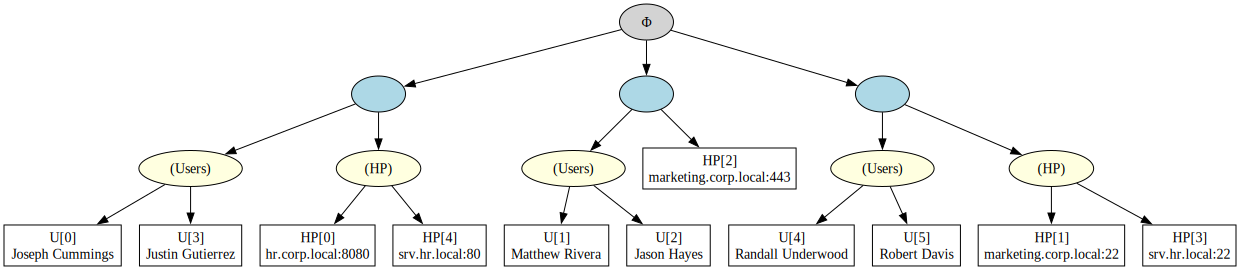

In [13]:


def build_custom_grouped_tree_graphviz(grouped, user_index_map, hostport_index_map):
    dot = Digraph(comment="Grouped Boolean Formula")
    dot.attr(rankdir='TB')

    # Root node
    dot.node("root", "Φ", shape="ellipse", style="filled", fillcolor="lightgray")

    for i, (host_set, users) in enumerate(grouped.items()):
        and_node = f"AND_{i}"
        dot.node(and_node, "∧", shape="ellipse", style="filled", fillcolor="lightblue")
        dot.edge("root", and_node)

        # User group (OR)
        if len(users) > 1:
            user_or_node = f"USER_OR_{i}"
            dot.node(user_or_node, "∨ (Users)", shape="ellipse", style="filled", fillcolor="lightyellow")
            dot.edge(and_node, user_or_node)
            for user in users:
                user_id = f"U_{user_index_map[user]}"
                label = f"U[{user_index_map[user]}]\\n{user}"
                dot.node(user_id, label, shape="box")
                dot.edge(user_or_node, user_id)
        else:
            user = users[0]
            user_id = f"U_{user_index_map[user]}"
            label = f"U[{user_index_map[user]}]\\n{user}"
            dot.node(user_id, label, shape="box")
            dot.edge(and_node, user_id)

        # HostPort group (OR)
        if len(host_set) > 1:
            hp_or_node = f"HP_OR_{i}"
            dot.node(hp_or_node, "∨ (HP)", shape="ellipse", style="filled", fillcolor="lightyellow")
            dot.edge(and_node, hp_or_node)
            for hp in host_set:
                hp_id = f"HP_{i}_{hostport_index_map[hp]}"
                label = f"HP[{hostport_index_map[hp]}]\\n{hp.host}:{hp.port}"
                dot.node(hp_id, label, shape="box")
                dot.edge(hp_or_node, hp_id)
        else:
            hp = list(host_set)[0]
            hp_id = f"HP_{i}_{hostport_index_map[hp]}"
            label = f"HP[{hostport_index_map[hp]}]\\n{hp.host}:{hp.port}"
            dot.node(hp_id, label, shape="box")
            dot.edge(and_node, hp_id)

    return dot

# Generate the Graphviz object
dot_graph = build_custom_grouped_tree_graphviz(grouped, user_index_map, hostport_index_map)
display(dot_graph)

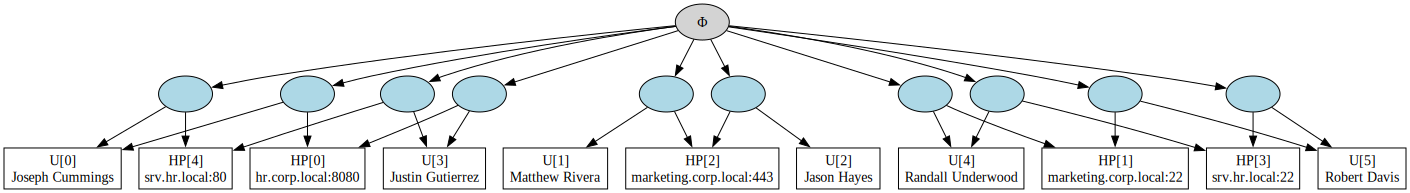

In [14]:
# Generate index maps
user_labels = list(flat.keys())
hostport_labels = sorted(set(hp for u in flat.values() for hp in u.keys()), key=lambda x: (x.host, x.port))
user_index_map = {u: i for i, u in enumerate(user_labels)}
hostport_index_map = {hp: i for i, hp in enumerate(hostport_labels)}

# Function for non-grouped formula tree
def build_flat_permission_tree_graphviz(flat, user_index_map, hostport_index_map):
    dot = Digraph(comment="Flat Boolean Formula")
    dot.attr(rankdir='TB')

    # Root node
    dot.node("root", "Φ", shape="ellipse", style="filled", fillcolor="lightgray")

    # For each user-hostport pair where permission is 1, create (user ∧ host) node
    clause_count = 0
    for user, access_map in flat.items():
        for hp, allowed in access_map.items():
            if allowed:
                and_node = f"AND_{clause_count}"
                dot.node(and_node, "∧", shape="ellipse", style="filled", fillcolor="lightblue")
                dot.edge("root", and_node)

                u_id = f"U_{user_index_map[user]}"
                u_label = f"U[{user_index_map[user]}]\\n{user}"
                dot.node(u_id, u_label, shape="box")
                dot.edge(and_node, u_id)

                hp_id = f"HP_{hostport_index_map[hp]}"
                hp_label = f"HP[{hostport_index_map[hp]}]\\n{hp.host}:{hp.port}"
                dot.node(hp_id, hp_label, shape="box")
                dot.edge(and_node, hp_id)

                clause_count += 1

    return dot

# Render and return image path
flat_tree = build_flat_permission_tree_graphviz(flat, user_index_map, hostport_index_map)
display(flat_tree)
